# Search

**Agent** - entity that perceives its environment and acts upon that environment

**State** - a configuration of the agent and its environment

**Initial State** - the state in which the agent begins

**Actions** - choices that can be made in a state. Actions(*s*) returns the set of actions that can be executed in state *s*. 



The AI is going to need some sort of encoding to describe the relationship between the state and the available actions that the entity can make. How do actions and state relate to one another?

**Transistion Model** - a description of what state results from performing any applicable action in any state. Result(*s, a*) returns the state resulting from performing action *a* in state *s*. 

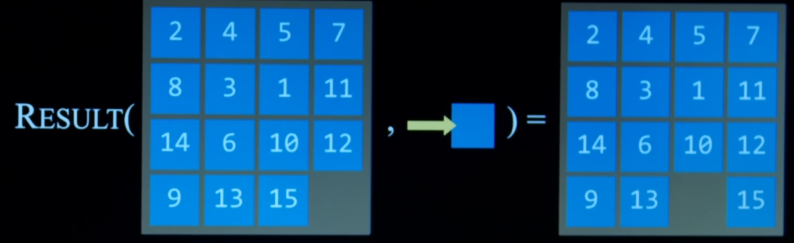

If we take this transition model and think of it more generally across the entire problem, we can form what we can call a state space. 

**State Space** - the set of all states reachable from the initial state by any sequences of actions. 

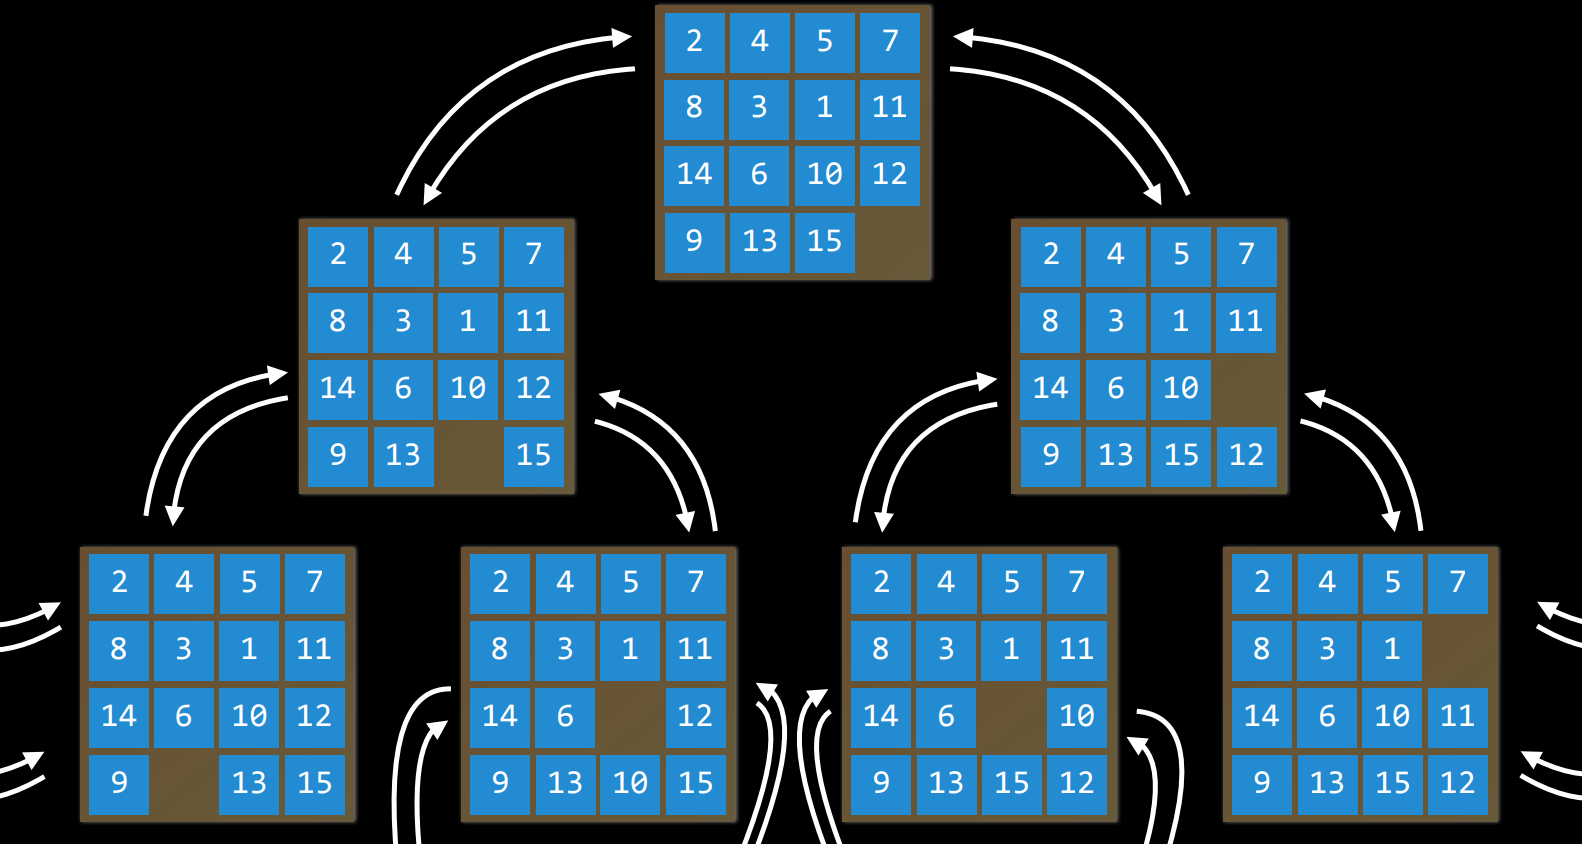

Oftentimes we simplify this by representing it as a graph with nodes and edges that connect nodes. Each node represents one of the states, and the edges are actions. 

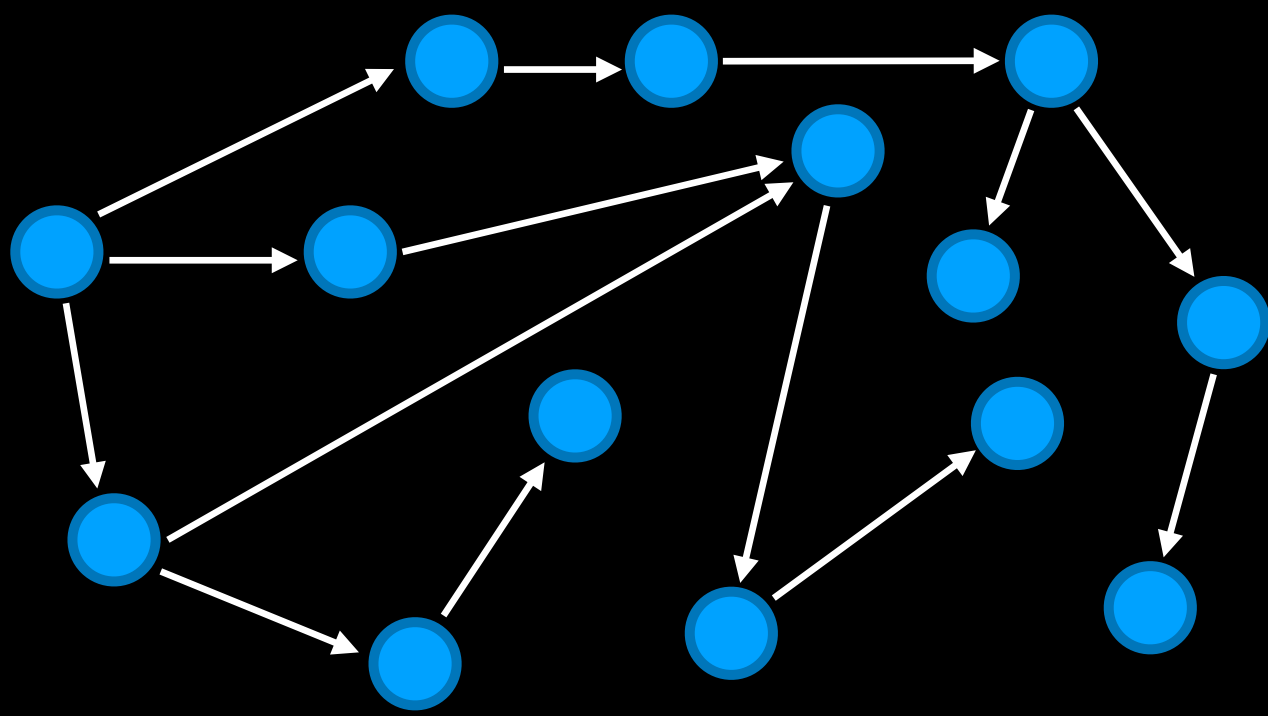

The last thing we need is to know when the AI is done solving the problem. 

**Goal Test** - way to determine whether a given state is a goal state. A problem may only have one goal (e.g., a maze) and other problems may have multiples ways of being solved. 

However, we don't only care about finding the goal, we want to find the goal at a low cost. 

**Path Cost** - numerical cost associated with a given path

When formulating search problems, we will give every path some sort of numerical cost - a number telling us how expensive it is to take that particular option. Then we tell the AI to not only find the goal, but find the goal while taking the path that minimizes the cost. 

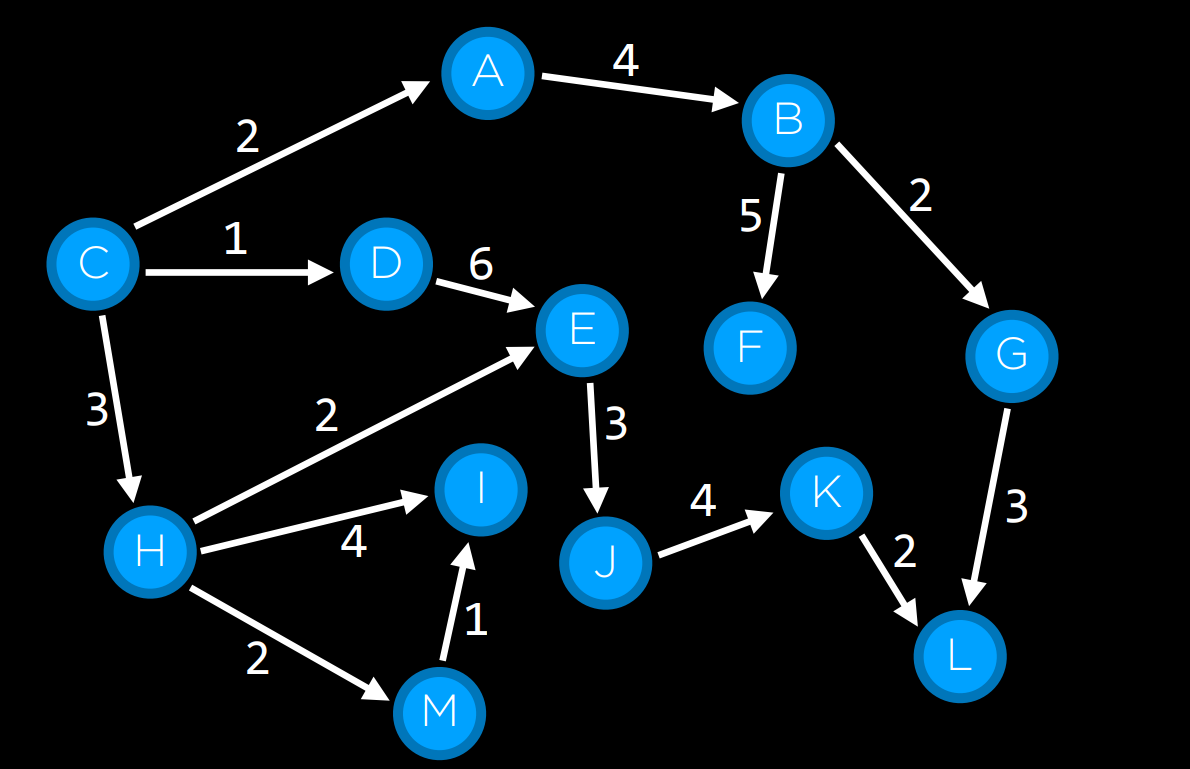

# Solving Search Problems

**Solution** - a sequence of actions that leads from the initial state to a goal state. 

**Optimal Solution** - a solution that has the lowest path cost among all solutions

We are going to solve these problems using a data structure called a node. 

**Node** - a data structure that keeps track of:
- a state
- a parent (node that generated this node)
- an action (action applied to partent to get node)
- a path cost (from initial state to node)

So what is the approach to starting to solve these problems? We are going to start from a particular state and explore from there. We have multiple options we can take and we are going to explore those options. Once we explore those options, we will find that there are even more options that become available. We are going to consider all the available options to be stored in a data structure called a frontier. The frontier is going to represent all of the things that we could explore next but haven't yet. 

Approach:
- Begin the search algorithm by starting with a frontier that just contains the initial state
- Repeat:
    - If the frontier is empty, then no solution
    - Remove a node from the frontier
    - If node contains goal state, return the solution
    - Expand node, add resulting nodes to the frontier
    
What could go wrong?
- infinite loops and never making progress. Need to keep track of where we have been before. 

Revised Approach:
- Start with a frontier that contains the initial state
- Start with an empty explored set
- Repeat:
    - If the frontier is empty, then no solution
    - Remove a node from the frontier
    - If node contains goal state, return the solution
    - Add the node to the explored set
    - Expand node, add resulting nodes to the frontier if they are not already in the frontier or the explored set

There is one step we need to cover in more detail - how we choose which node to remove from the frontier. 

# Depth  First Search

**Stack** - last-in first-out data type

We remove and explore the nodes in a last-in first-out approach. This will have us go very deep into the graph

**Depth-First Search** - search algorithm that always expands the deepest node in the frontier

There is also another algorithm that behaves similarly, but explores the shallowest node first, called breadth-first search. 

**Breadth-First Search** - search algorithm that always expands the shallowest node in the frontier

With BFS, we use a queue instead of a stack. 

**Queue** - first-in first-out data type

In [18]:
import sys

class Node():
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action
    
class StackFrontier():
    def __init__(self):
        self.frontier = []
        
    def add(self, node):
        self.frontier.append(node)
        
    def contains_state(self, state):
        return any(node.state == state for node in self.frontier)
    
    def empty(self):
        return len(self.frontier) == 0
    
    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[-1]
            self.frontier = self.frontier[:-1]
            return node
        
class QueueFrontier(StackFrontier):
    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[0]
            self.frontier = self.frontier[1:]
            return node
        
class Maze():
    def __init__(self, filename):
        
        # Read file and set height and width of maze
        with open(filename) as f:
            contents = f.read()
            
        # Validate start and goal
        if contents.count("A") != 1:
            raise Exception("Maze must have exactly one start point.")
        if contents.count("B") != 1:
            raise Exception("Maze must have exactly one end point.")
        
        # Determine height and width of maze
        contents = contents.splitlines()
        self.height = len(contents)
        self.width = max(len(line) for line in contents)
        
        # Keep track of walls
        self.walls = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if contents[i][j] == "A":
                        self.start = (i, j)
                        row.append(False)
                    elif contents[i][j] == "B":
                        self.goal = (i, j)
                        row.append(False)
                    elif contents[i][j] == " ":
                        row.append(False)
                    else:
                        row.append(True)
                except IndexError:
                    row.append(False)
            self.walls.append(row)
        self.solution = None
        
    def print(self):
        solution = self.solution[1] if self.solution is not None else None
        print()
        for i, row in enumerate(self.walls):
            for j, col  in enumerate(row):
                if col:
                    print("#", end="")
                elif (i, j) == self.start:
                    print("A", end="")
                elif (i, j) == self.goal:
                    print("B", end="")
                elif solution is not None and (i, j) in solution:
                    print("*", end="")
                else:
                    print(" ", end="")
            print()
        print()
    
    def neighbors(self, state):
        row, col = state
        
        # All possible actions
        candidates = [
            ("up", (row - 1, col)), 
            ("down", (row + 1, col)), 
            ("left", (row, col - 1)), 
            ("right", (row, col + 1))
        ]
        
        # Ensure actions are valid
        result = []
        for action, (r, c) in candidates:
            try:
                if not self.walls[r][c]:
                    result.append((action, (r,c)))
            except IndexError:
                continue
        return result
    
    def solve(self):
        """Finds a solution to maze, if one exists."""
        
        # Keep track of number of states explored
        self.num_explored = 0
        
        # Initialize frontier to just the starting position
        start = Node(state = self.start, parent = None, action = None)
        frontier = QueueFrontier()
        frontier.add(start)
        
        # Initialize an empty explored set
        self.explored = set()
        
        # Keep looping until solution found
        while True:
            
            # If nothing left in frontier, then no path
            if frontier.empty():
                raise Exception("no solution")
            
            # Choose a node from the frontier
            node = frontier.remove()
            self.num_explored += 1
                
            # If node is the goal, then we have a solution
            if node.state == self.goal:
                actions = []
                cells = []
                
                # Follow parent nodes to find solution
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                return 
            
            # Mark node as explored
            self.explored.add(node.state)
            
            # Add neighbors to frontier
            for action, state in self.neighbors(node.state):
                if not frontier.contains_state(state) and state not in self.explored:
                    child = Node(state = state, parent = node, action = action)
                    frontier.add(child)
            
    def output_image(self, filename, show_solution=True, show_explored=False):
        from PIL import Image, ImageDraw
        cell_size = 50
        cell_border = 2

        # Create a blank canvas
        img = Image.new(
            "RGBA",
            (self.width * cell_size, self.height * cell_size),
            "black"
        )
        draw = ImageDraw.Draw(img)

        solution = self.solution[1] if self.solution is not None else None
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):

                # Walls
                if col:
                    fill = (40, 40, 40)

                # Start
                elif (i, j) == self.start:
                    fill = (255, 0, 0)

                # Goal
                elif (i, j) == self.goal:
                    fill = (0, 171, 28)

                # Solution
                elif solution is not None and show_solution and (i, j) in solution:
                    fill = (220, 235, 113)

                # Explored
                elif solution is not None and show_explored and (i, j) in self.explored:
                    fill = (212, 97, 85)

                # Empty cell
                else:
                    fill = (237, 240, 252)

                # Draw cell
                draw.rectangle(
                    ([(j * cell_size + cell_border, i * cell_size + cell_border),
                      ((j + 1) * cell_size - cell_border, (i + 1) * cell_size - cell_border)]),
                    fill=fill
                )

        img.save(filename)

In [19]:
m = Maze('maze2.txt')
m.print()


###                 #########
#   ###################   # #
# ####                # # # #
# ################### # # # #
#                     # # # #
##################### # # # #
#   ##                # # # #
# # ## ### ## ######### # # #
# #    #   ##B#         # # #
# # ## ################ # # #
### ##             #### # # #
### ############## ## # # # #
###             ##    # # # #
###### ######## ####### # # #
###### ####             #   #
A      ######################



In [20]:
m.solve()

In [21]:
print("States Explored:", m.num_explored)
print("Solution:")
m.print()
m.output_image("maze.png", show_explored=True)

States Explored: 77
Solution:

###                 #########
#   ###################   # #
# ####                # # # #
# ################### # # # #
#                     # # # #
##################### # # # #
#   ##********        # # # #
# # ##*### ##*######### # # #
# #****#   ##B#         # # #
# #*## ################ # # #
###*##             #### # # #
###*############## ## # # # #
###****         ##    # # # #
######*######## ####### # # #
######*####             #   #
A******######################



So which is better? DFS or BFS? Depends on the maze. We can make the algorithm a bit more intelligent though. If we know the coordinate of where we are at and the coordinate of the goal, we can make decisions on which path to select by trying to move closer at each decision point. 

**Uninformed Search** - search strategy that uses no problem-specific knowledge. DFS and BFS didn't care about the structure of the maze. They just look at the actions available and choose from those actions. 

**Informed Search** - search strategy that uses problem-specific knowledge to find solutions more efficiently. 

# Greedy Best-First Search

**Greedy Best-First Search** - search algorithm that expands the node that is closest to the goal, as estimated by a heuristic function *h(n)*. The algorithm isn't going to know for sure if the node is in fact closer to the goal, otherwise we would have the solution. We are estimating based on a heuristic. 

At each decicion point, you use the heuristic to determine which way to go. 

Manhattan distance is how many squares you need to travel up/down and left/right to get to the goal, ignoring walls. 

Greedy algorithms make the best decisions locally and is not guaranteed to find the optimal solution

We would like to find the optimal solution so how do we change the algorithm to be better?

# A* Search

**A* Seach** - search algorithm that expands node with lowest value of *g(n) + h(n)*

*g(n)* = cost to reach node

*h(n)* = estimate cost to goal

The Greedy Best-First Search only cares about the estimated distance between it and the goal. A* takes into consideration how far it is away from the goal and how far did it have to travel to get there. 

A* search may have to explore some other paths but the solution found is in fact optimal. 

A* is optimal under certain conditions:
- *h(n)* is admissible (never overestimates the true cost) (it should never think that you are further away from the goal than you actually are)
- *h(n)* is consistent (for every node *n* and successor *n'* with step cost *c*, *h(n) <= h(n') + c*) - if I am here in this state right now, the heuristic value from me to the goal shouldn't be more than the heuristic value of my successor (the next place I could go) plus however much it would cost me to just make that step.

# Adversarial Search

So far we have only explored search algorithms where there is only one agent. Sometimes though we will be in situations where we are an agent trying to make decisions and there is someone else who is fighting against me that has the opposite objective. Such as in tic-tac-toe. 

# Minimax

Minimax is a good algorithm to use when there are two players that take turns one after the other. Such as tic-tac-toe. To help a computer understand the outcomes of tic-tac-toe, we can assign values to each outcome. -1 if O wins, 0 if no one wins, and +1 if X wins. 

Let us call the X player the max player and the O player the min player. 

In a Minimax algorithm, the max player aims to maximize the score. The min player aims to minimize the score. 

To encode it into an AI, the game is going to need a few of things. 
- Some initial state, $s_0$, 
- a player function, $player(s)$, which returns which player to move in state $s$, 
- some notion of actions, $actions(s)$, which retusn legal moves in state $s$
- some notion of a transition model, $result(s,a)$ which returns state after action $a$ taken in state $s$
- to know when the game is over, $terminal(s)$, which checks if state $s$ is a terminal state
- a utility function, $utility(s)$, which is a final numerical value for terminal state $s$

So the logic of Minimax is to consider all of the possible options that you can take, then put yourself in your opponent's shoes and consider all the moves that they can make. 

- Given a state $s$:
    - MAX picks action $a$ in $actions(s)$ that produces highest value of $min-value(results(s, a))$ (this means that I want to select the option that gives me the highest score of actions, $a$. But what score is that going to have? To calculate that, I need to know what my opponent, the min player, is going to do if they try to minimize the value of the state that results. So we say, what state results after I take this action, and what happens when the min player tries to minimize the value of that state? I consider that for all of my possible options. And after I have considere all possible options, I pick the action A that has the highest value.
    - MIN picks action $a$ in $actions(s)$ that produces smallest value of $max-value(results(s, a))$. The min player will consider all the possible actions they can take if it is their turn, and they are going to pick the action that has the smallest possible value of all the options. And the way they know what the smallest possible value of all the options is, is by considering what the max player is going to do, by saying, what is the result of applying this action to the current state and then what would the max player try to do?
    
So how do you actually calculate the value of a state if you are trying to maximize its value, and how do you calculate the value of a state if you are trying to minimize the value? If you can do that, then we have an entire implementation of the Minimax algorithm. 

function MAX-VALUE(state):
    if TERMINAL(state):
        return UTILITY(state)
    v = -inf 
    for action in ACTIONS(state):
        v = MAX(v, MIN-VALUE(RESULT(state, action)))
    return v
    
So let's implement this maxValue function that takes a state and returns the value of that state if I am trying to maximize the value of the state. The first thing you check for is to see if the game is over. If the game is over, just check who won. If the game isn't over, we need to do some recursive thinking because we have to think about what our opponent is going to do on the next move. 

So we want to calculate the value of the current state we are in, and we want it to be as high as possible (if we are the MAX player). We will track it in a variable called v. And if I want the value to be as high as possible, I need to give v an initial value and we will set it to be as low as possible. 

So now for every action that we can take, we want to compare its v-value with our current v-value and take the bigger of the two. The v-value of the state is going to be the minimum value of the result of doing some action on that state. In other words, from that state, what is the best that the min player can do. So whatever the resulting score is of the min value of that state, compare it to my current best value, and just pick the maximum of the two. 

For the min player, the logic is just the opposite:

function MIN-VALUE(state):
    if TERMINAL(state):
        return UTILITY(state)
    v = +inf
    for action in ACTIONS(state):
        v = MIN(x, MAX-VALUE(RESULT(state, action)))
    return v
    
So these two functions call each other back and forth until they reach a terminal state. 

As you can imagine, the earlier we are in the game, the more options there are going to be, so what kind of optimizations can we make?

# Alpha-Beta Pruning

You can keep track of best that you can do within each path, and when it is clear that one path is going to have a worse score, no matter what, than another path, don't bother calculating the rest of that path. 

However as games get more complex and there are many states to consider (e.g., chess), we have to use something else. 

# Depth-Limited Minimax

Only looking so many moves ahead. But how do you calculate the value of a state if you don't reach the terminal? We need to add another function called the evaluation function - a function that estimates the expected utility of the game from a given state. How good the evaluation function is determines how good the AI is. 